# Notebook to Investigate LSTM Performance Variance by Huc Type

Make sure to import the following packages:  

```bash
# Run this command from within the SnowML directory after cloning the SnowML repo
pip install -e==1.25.0


In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
from snowML.viz import vis_utils as vu
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import combinations
from scipy.stats import ttest_ind_from_stats
from shapely import wkt

In [2]:
# ignore future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# initialize erathengine credentials
import ee
ee.Authenticate(auth_mode='notebook')

True

# Step1 - Get MLFlow Metrics

In [4]:
# Upload Metrics + Snow Class Data created by Notebook "LSTM_By_Huc_Download_Metrics"
# These are the metrics for the last epoch (epoch 10) for each huc_id, combined with snow_type data 
f = "single_all_metrics_w_snow_types_and_elev_Tum_Local.csv"
df_metrics = pd.read_csv(f)
print(df_metrics.shape)
df_metrics.head(2)

(57, 10)


,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,color_snow_type,mean_elevation,Huc_08,Huc_08_nm,geometry
0,180400090101,Lyell Fork,0.068745,0.658103,Montane Forest,darkgreen,3149.375244,18040009,Upper Tuolumne,POLYGON ((-119.2173883465124 37.81831520058611...
1,180400090102,Dana Fork,0.059666,0.661919,Tundra,white,3190.795166,18040009,Upper Tuolumne,POLYGON ((-119.19927543799085 37.8848311649521...


In [5]:
grouped_counts = df_metrics.groupby('Huc_08')['Predominant_Snow'].value_counts()
print(grouped_counts)

Huc_08    Predominant_Snow
18040009  Ephemeral           35
          Maritime            12
          Prairie              5
          Montane Forest       4
          Tundra               1
Name: count, dtype: int64


In [6]:
def extract_subdict(original_dict, keys_to_extract):
    return {key: original_dict[key] for key in keys_to_extract if key in original_dict}

In [7]:
# color_map with warm colors 
color_map_snow = {
    "Montane Forest": "darkgreen",  
    "Maritime": "blue",
    "Ephemeral": "#E6E6FA",  # Hex code for lavender
    "Prairie": "lightgreen", 
    "Tundra": "darkgray"
}


In [8]:
# update the snow colors column with the new colors 
df_metrics['Snow_Type_Color'] = df_metrics['Predominant_Snow'].map(color_map_snow)
df_metrics.head(2)

,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,color_snow_type,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color
0,180400090101,Lyell Fork,0.068745,0.658103,Montane Forest,darkgreen,3149.375244,18040009,Upper Tuolumne,POLYGON ((-119.2173883465124 37.81831520058611...,darkgreen
1,180400090102,Dana Fork,0.059666,0.661919,Tundra,white,3190.795166,18040009,Upper Tuolumne,POLYGON ((-119.19927543799085 37.8848311649521...,darkgray


# Step 2 - Define Plotting And Analytics Functions 

moved to vu module 

# Step 3 Create ScatterPlots

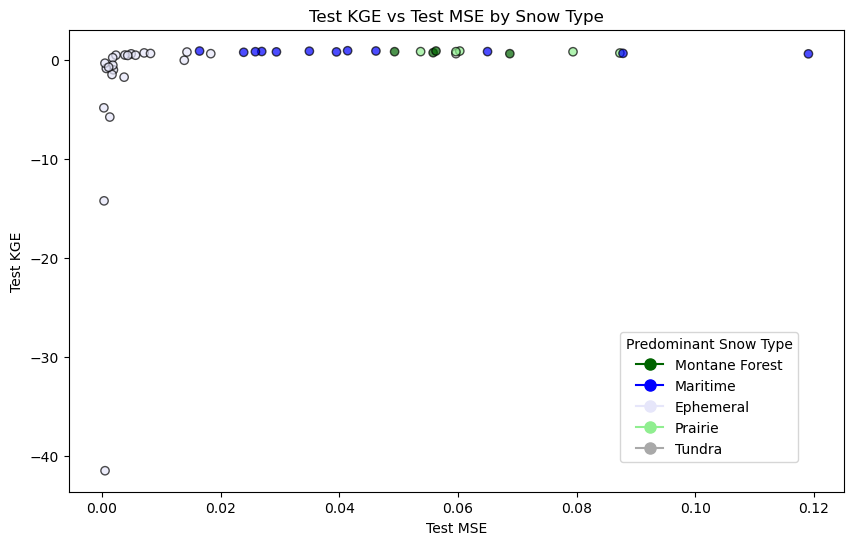

In [9]:
# All results 
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type"
vu.plot_scatter(df_metrics, "Test MSE", "Test KGE", color_map_snow, title = ttl)

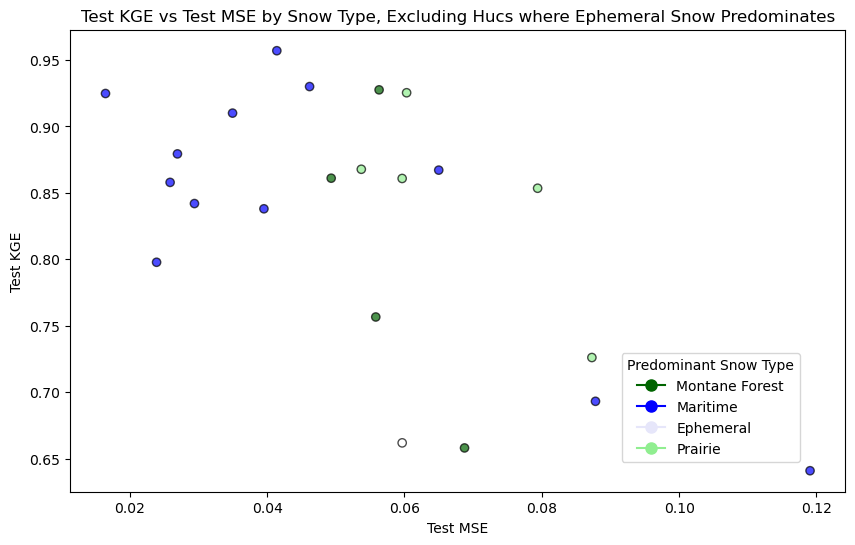

In [10]:
# Results with Ephemeral Removed 
df_noE = df_metrics[df_metrics["Predominant_Snow"] != "Ephemeral"]
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral", "Prairie"])
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type, Excluding Hucs where Ephemeral Snow Predominates"
vu.plot_scatter(df_noE, "Test MSE", "Test KGE", color_map, title = ttl)

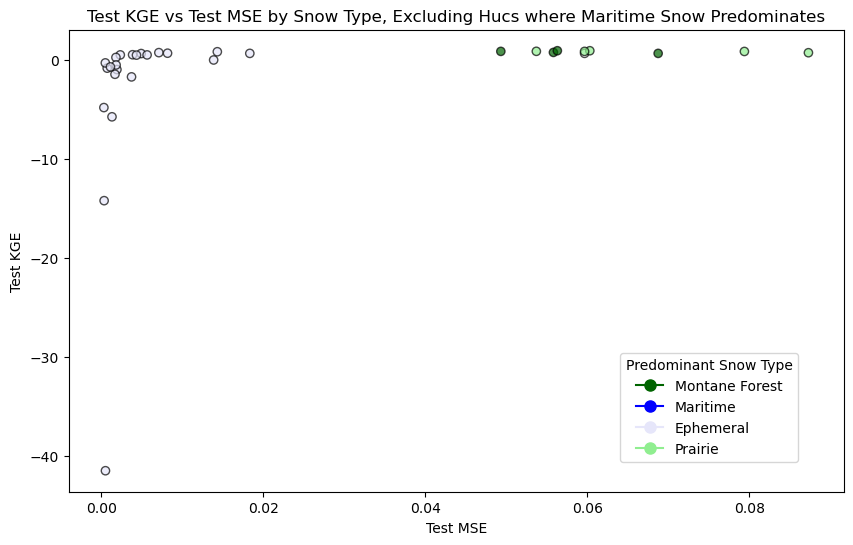

In [11]:
# Results with Maritime Removed 
df_noMar = df_metrics[df_metrics["Predominant_Snow"] != "Maritime"]
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral", "Prairie"])
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type, Excluding Hucs where Maritime Snow Predominates"
vu.plot_scatter(df_noMar, "Test MSE", "Test KGE", color_map, title = ttl)

# Step 5 - Create box and whisker plot by Snow Type; Run T-Tests

In [12]:
# Exclude Prarie and Boreal sub, hucs.  Optionally exclude Ephemeral 
snow_types_to_include = ["Montane Forest", "Ephemeral", "Maritime", "Prairie", "Tundra"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]

snow_types_to_include = ["Montane Forest", "Maritime", "Prairie", "Tundra"]
filtered_df_noE = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]



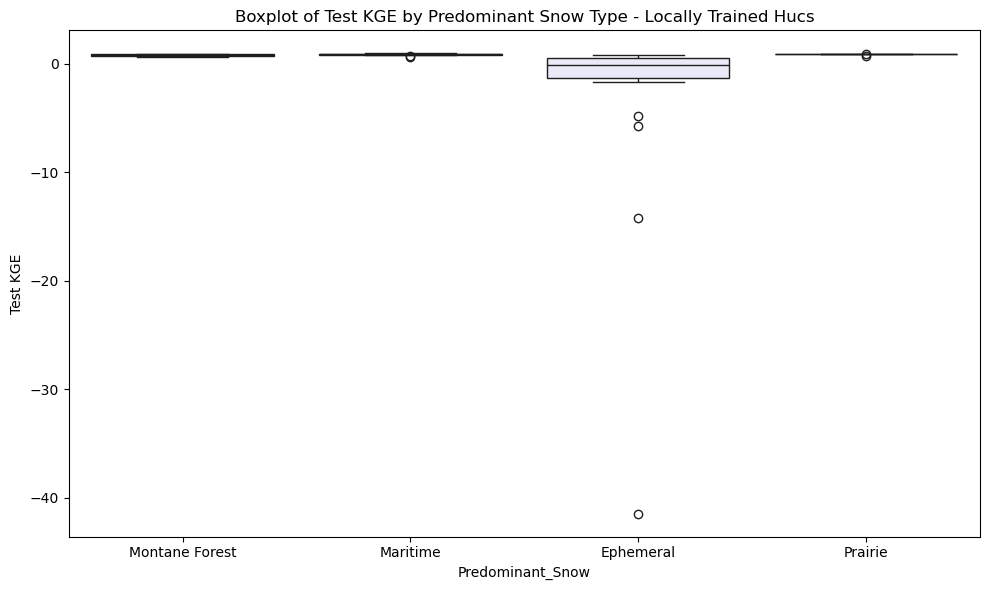

,count,median,mean,std
Predominant_Snow,,,,
Ephemeral,22,-0.155023,-3.042555,9.221957
Maritime,12,0.862520,0.844846,0.094946
Montane Forest,4,0.808845,0.800831,0.118329
Prairie,5,0.860853,0.846722,0.073169
Tundra,1,0.661919,0.661919,NaN


In [13]:
parameter = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral", "Prairie"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df, parameter, ttl, group_by, color_map = color_map)
grouped_data


In [14]:
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

,Group1,Group2,P-Value
0,Ephemeral,Maritime,0.061314
1,Ephemeral,Montane Forest,0.064135
2,Ephemeral,Prairie,0.061207
3,Ephemeral,Tundra,NaN
4,Maritime,Montane Forest,0.533698
5,Maritime,Prairie,0.965814
6,Maritime,Tundra,NaN
7,Montane Forest,Prairie,0.528750
8,Montane Forest,Tundra,NaN
9,Prairie,Tundra,NaN


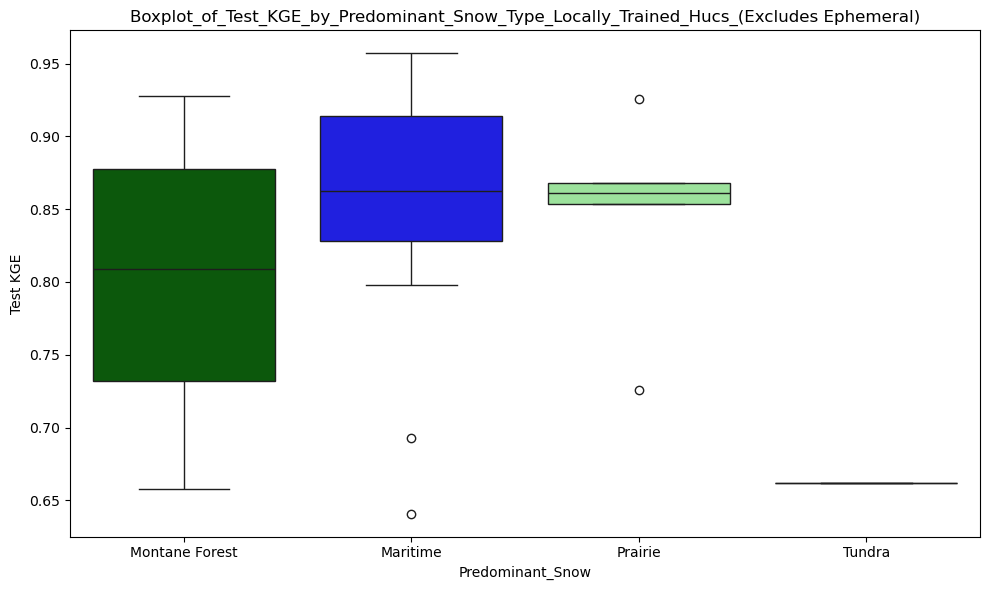

,count,median,mean,std
Predominant_Snow,,,,
Maritime,12,0.862520,0.844846,0.094946
Montane Forest,4,0.808845,0.800831,0.118329
Prairie,5,0.860853,0.846722,0.073169
Tundra,1,0.661919,0.661919,NaN


In [21]:
parameter = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Prairie", "Tundra"])
ttl = f"Boxplot_of_Test_KGE_by_Predominant_Snow_Type_Locally_Trained_Hucs_(Excludes Ephemeral)"
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df_noE, parameter, ttl, group_by, color_map = color_map, save_local = True)
grouped_data 


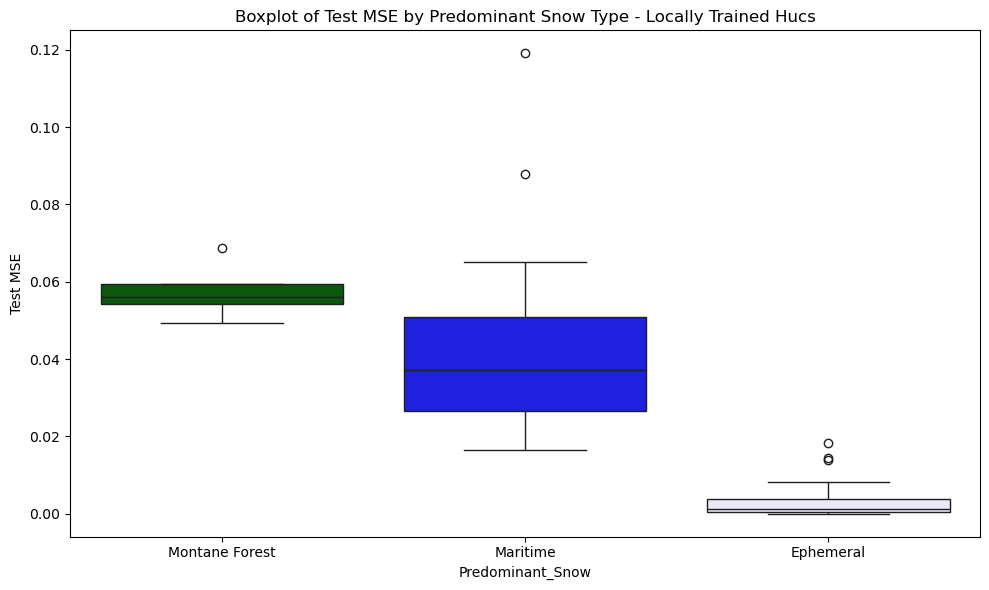

,Group1,Group2,P-Value
0,Ephemeral,Maritime,0.000408
1,Ephemeral,Montane Forest,0.000655
2,Ephemeral,Prairie,0.000487
3,Ephemeral,Tundra,NaN
4,Maritime,Montane Forest,0.264945
5,Maritime,Prairie,0.064767
6,Maritime,Tundra,NaN
7,Montane Forest,Prairie,0.213683
8,Montane Forest,Tundra,NaN
9,Prairie,Tundra,NaN


In [16]:
parameter = "Test MSE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df, parameter, ttl, group_by, color_map = color_map)
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

In [17]:
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

,Group1,Group2,P-Value
0,Ephemeral,Maritime,0.000408
1,Ephemeral,Montane Forest,0.000655
2,Ephemeral,Prairie,0.000487
3,Ephemeral,Tundra,NaN
4,Maritime,Montane Forest,0.264945
5,Maritime,Prairie,0.064767
6,Maritime,Tundra,NaN
7,Montane Forest,Prairie,0.213683
8,Montane Forest,Tundra,NaN
9,Prairie,Tundra,NaN


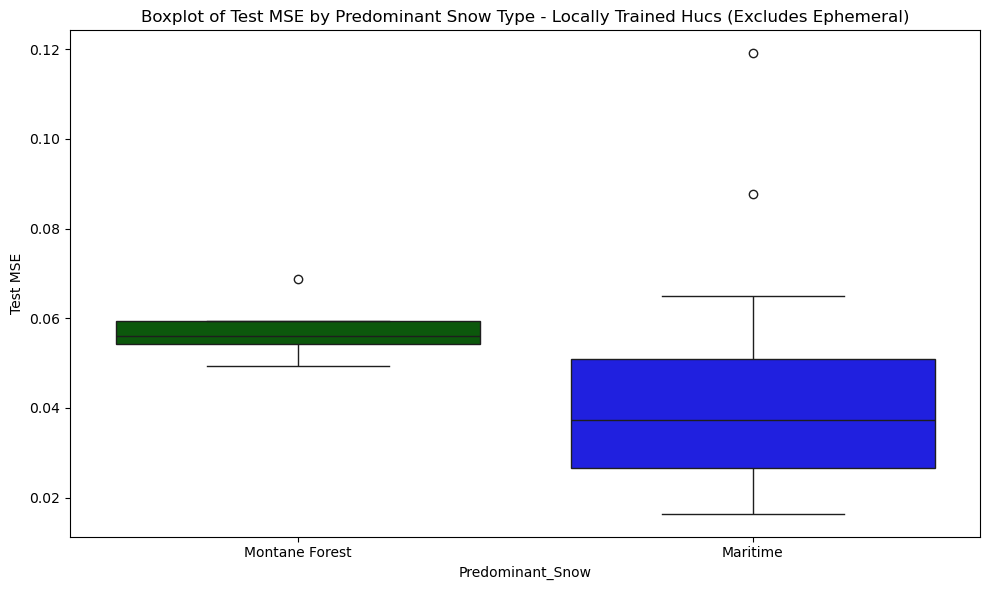

,Group1,Group2,P-Value
0,Ephemeral,Maritime,0.000408
1,Ephemeral,Montane Forest,0.000655
2,Ephemeral,Prairie,0.000487
3,Ephemeral,Tundra,NaN
4,Maritime,Montane Forest,0.264945
5,Maritime,Prairie,0.064767
6,Maritime,Tundra,NaN
7,Montane Forest,Prairie,0.213683
8,Montane Forest,Tundra,NaN
9,Prairie,Tundra,NaN


In [18]:

parameter = "Test MSE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs (Excludes Ephemeral)"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df, parameter, ttl, groupby_column = group_by, color_map = color_map)
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

# Step 6 Examine by Basin

# Step 7 Examine by Elevation 

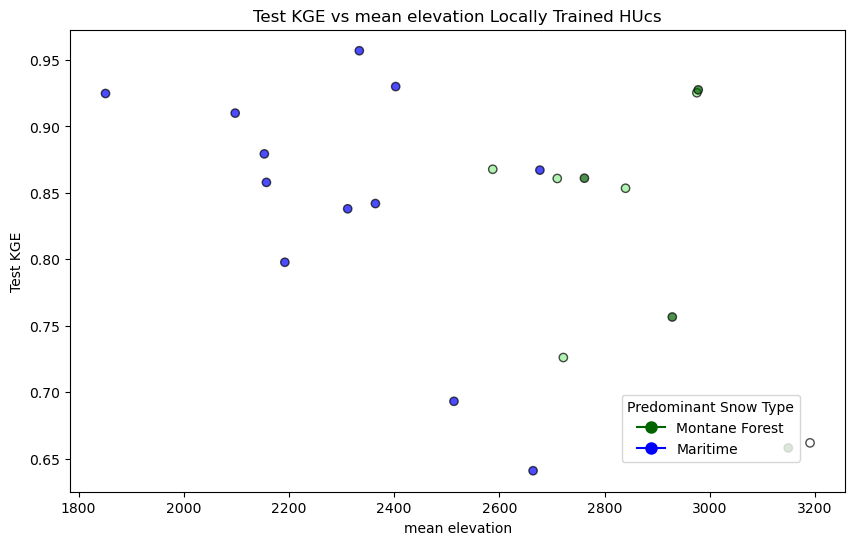

In [19]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
ttl = f"{y_var_name}_vs_{x_var_name}_Locally Trained HUcs"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
vu.plot_scatter(filtered_df_noE, x_var_name, y_var_name, color_map, title = ttl)

In [20]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"{y_var_name}_vs_{x_var_name}_Locally Trained HUCs"
plot_scatter(filtered_df, x_var_name, y_var_name, color_map, title = ttl)

NameError: name 'plot_scatter' is not defined

In [ ]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
for snow_type in ["Montane Forest", "Maritime", "Ephemeral"]:
    ttl = f"{y_var_name}_vs_{x_var_name}_Locally Trained Hucs, {snow_type} Only"
    plot_scatter(filtered_df[filtered_df["Predominant_Snow"] == snow_type], x_var_name, y_var_name, color_map_snow, title = ttl, show_legend = False)